In [1]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
#import statsmodels
import statsmodels.api as sm
import scipy as sc
from scipy.stats import binned_statistic_2d, boxcox
from sklearn import datasets, linear_model, metrics
from itertools import product
import statsmodels.formula.api as smf


Populating the interactive namespace from numpy and matplotlib


C:\Users\nlavr\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Читаем подготовленные данные за период с 2015-02 по 2015-08 для ячейки 1126:

In [2]:
f_data = pd.read_pickle('TaxiData/stat_2016-01_2016-04_1326.dat')
print f_data.shape
f_data.head()

#f_data.tpep_pickup_datetime

(2903, 3)


,tpep_pickup_datetime,region,count
90,2016-01-01 00:00:00,1326,103.0
396,2016-01-01 01:00:00,1326,153.0
743,2016-01-01 02:00:00,1326,167.0
1101,2016-01-01 03:00:00,1326,168.0
1466,2016-01-01 04:00:00,1326,121.0


Будем использовать время как индекс:

In [51]:

data = f_data.sort_values('tpep_pickup_datetime')
ind = pd.DatetimeIndex(data.tpep_pickup_datetime.sort_values(), dtype='datetime64[ns]', freq='h')

data = data.set_index(ind)
data = data[720 * 2:]
print data.shape
data.head()

(1463, 3)


,tpep_pickup_datetime,region,count
tpep_pickup_datetime,,,
2016-03-01 00:00:00,2016-03-01 00:00:00,1326,25.0
2016-03-01 01:00:00,2016-03-01 01:00:00,1326,18.0
2016-03-01 02:00:00,2016-03-01 02:00:00,1326,9.0
2016-03-01 03:00:00,2016-03-01 03:00:00,1326,8.0
2016-03-01 04:00:00,2016-03-01 04:00:00,1326,5.0


Исходный ряд:

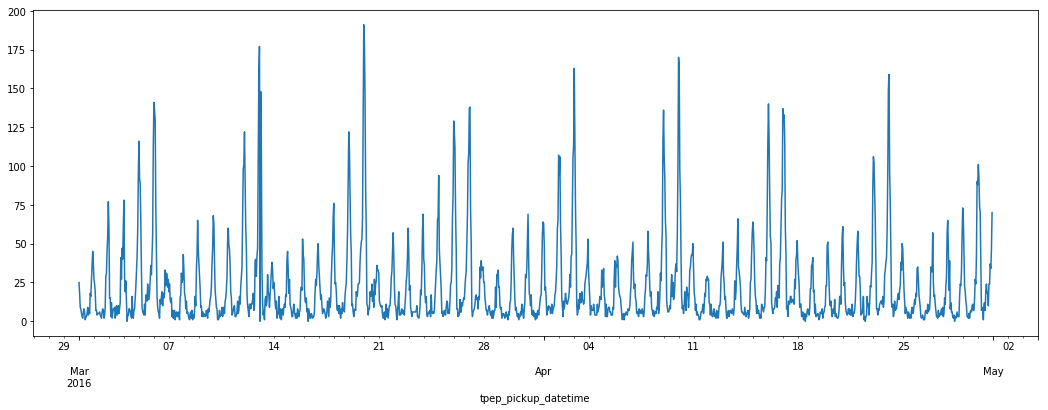

In [52]:
plt.rcParams["figure.figsize"] = (18,6)
data['count'][::].plot()

Составим признаки для регресии

In [54]:
#Зададим порядковый номер записи
data['rn'] =  range(1, data.shape[0] + 1)

K = 7
for k in range(1, K + 1):
    data.loc[:,'s'+ str(k)] = np.sin(data['rn'] * 2 * np.pi * k / 168)
    data.loc[:,'c'+ str(k)] = np.cos(data['rn'] * 2 * np.pi * k / 168)
    
def getDayPart(date_time):
   
    if (date_time.weekday() == 6):
        if 4 <= date_time.hour and date_time.hour <= 8:
            return 0;
        if 9 <= date_time.hour and date_time.hour <= 18:
            return 1;
        if 19 <= date_time.hour or date_time.hour <= 5:
            return 0;
        
    else:
        if 1 <= date_time.hour and date_time.hour <= 6:
            return 0;
        if 7 <= date_time.hour and date_time.hour <= 18:
            return 1;
        if 19 <= date_time.hour and date_time.hour <= 23:
            return 2;
        if 23 < date_time.hour or date_time.hour == 0:
            return 0;

        
data.loc[:, 'day_part'] = data.index.map(getDayPart)


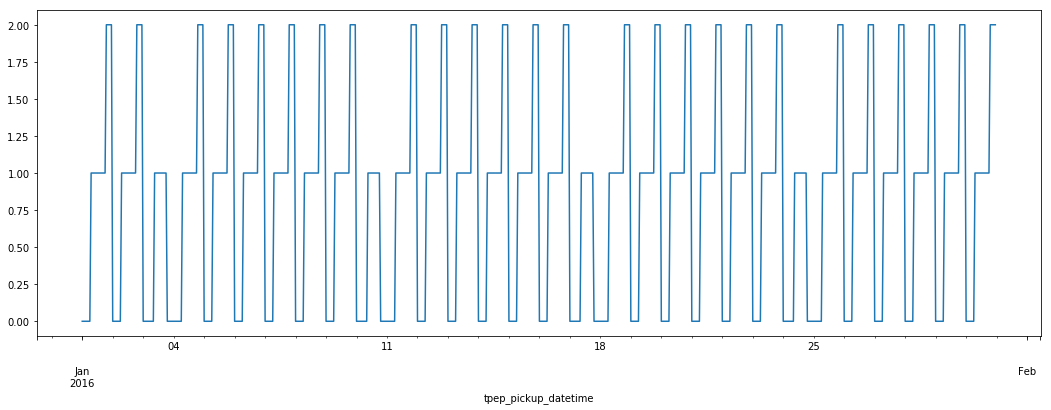

In [40]:
data.loc[:,'day_part'].plot()
#data.loc[:,'c2'].plot()

Сделем регрессию ряда на сгенерированные выше признаки и посмотрим на остатки регресии:

12.111257030805179


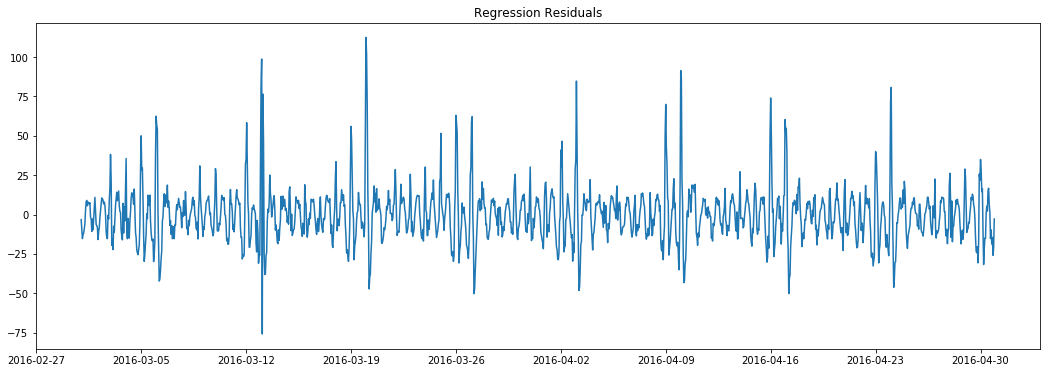

In [56]:
x_names = []
for k in range(1, K + 1):
    x_names.append('s'+ str(k))
    x_names.append('c'+ str(k))

#x_names.append('day_part')
    
m1 = smf.ols('count ~ ' + str.join(' + ', x_names), 
             data=data)
fitted = m1.fit()
plt.rcParams["figure.figsize"] = (18,6)
plt.title('Regression Residuals')
plt.plot(fitted.resid)

predictions = fitted.predict(data[x_names])
print metrics.mean_absolute_error(data['count'], predictions)

Проверим среднее и критерий Дики-Фуллера для остатков и визуально изучим STL декомпозицию:

7.50017332191e-16
1.166523423233157e-05


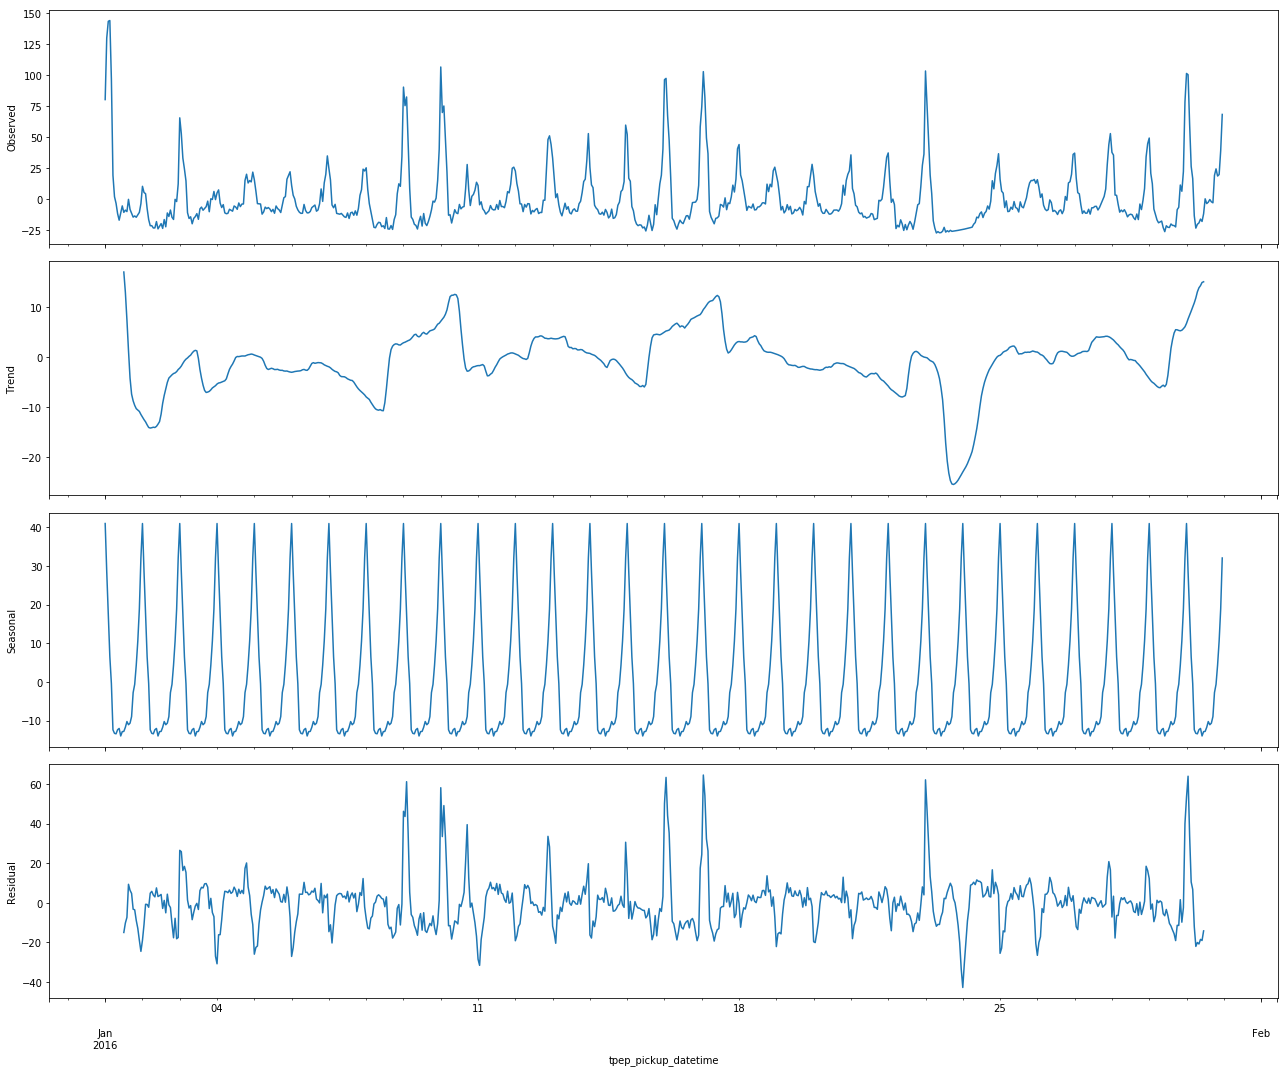

In [20]:
print fitted.resid.mean()
print sm.tsa.stattools.adfuller(fitted.resid)[1]

plt.rcParams["figure.figsize"] = (18,15)
dec = sm.tsa.seasonal_decompose(fitted.resid)
dec.plot()
pylab.show()
#print dec.seasonal[:24*7].plot()
#plt.show()

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, однако визуально видно изменение
тренда. Проведем cуточное дифференцирование (24 часа)

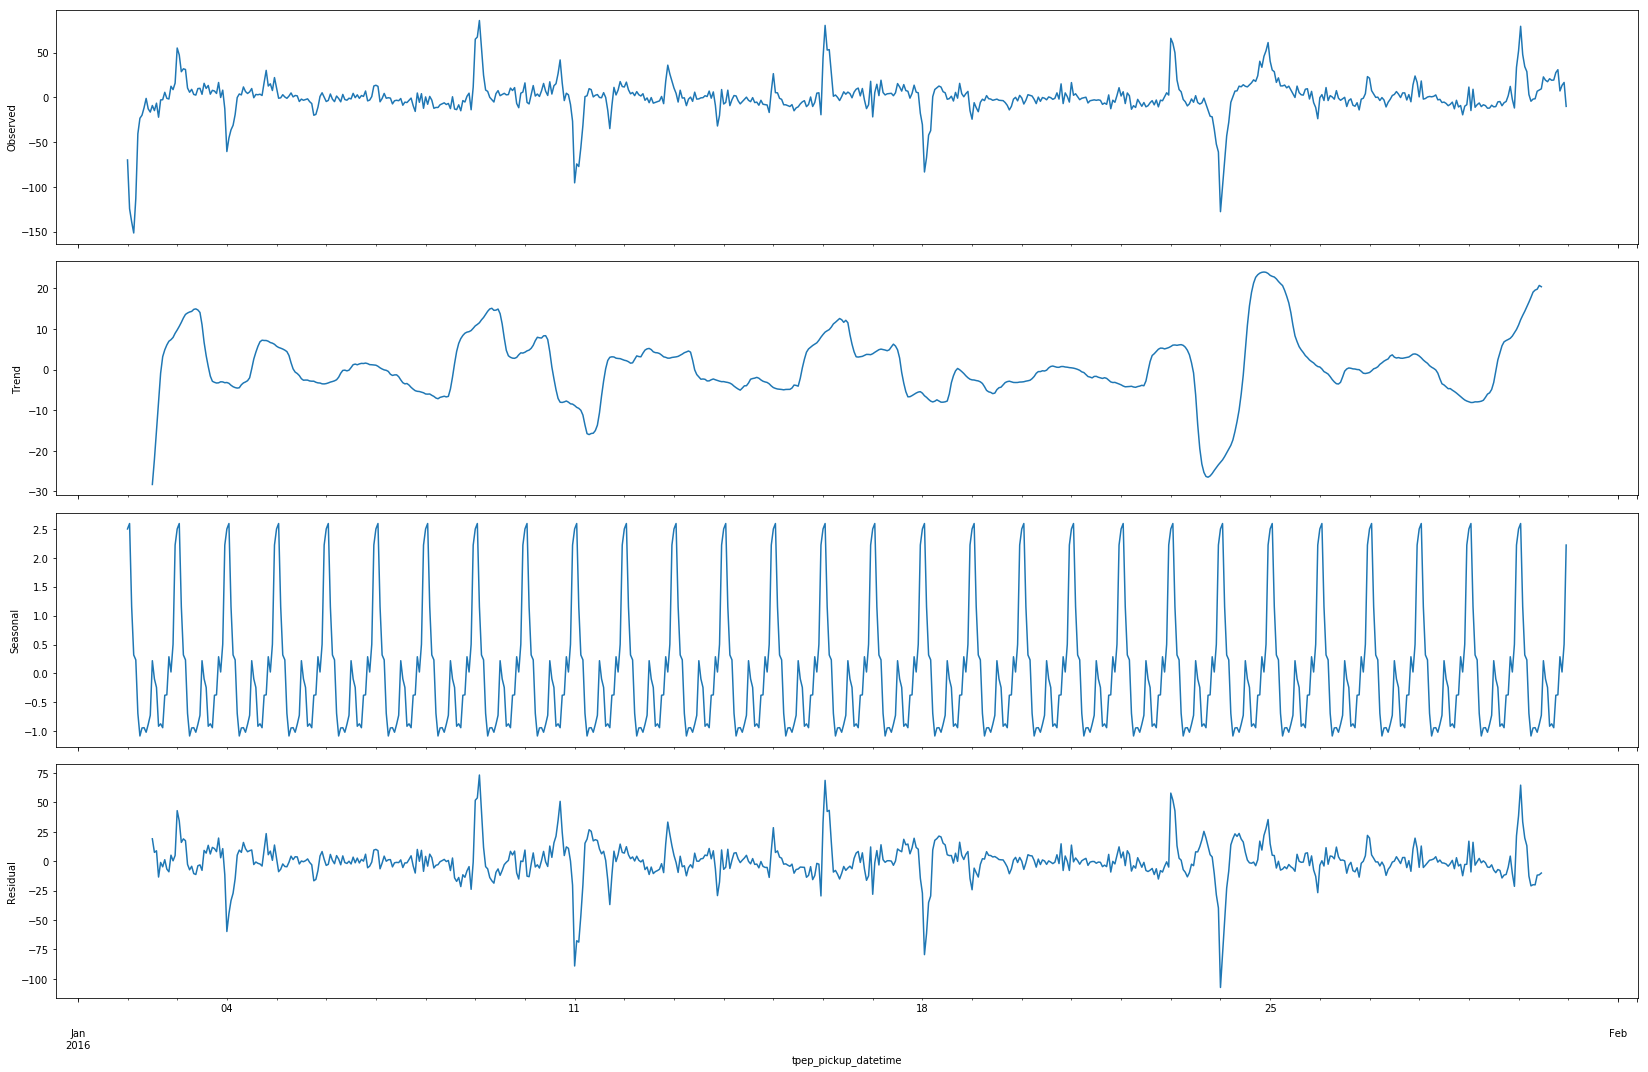

In [21]:
lag = 24
data['resid_diff_24'] = fitted.resid - fitted.resid.shift(lag)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24'][lag:])

plt.rcParams["figure.figsize"] = (23,15)
dec.plot()
#dec.trend.plot()
pylab.show()

Проведем еще одно суточное дифференцирование и одно обычное дифференцирование:

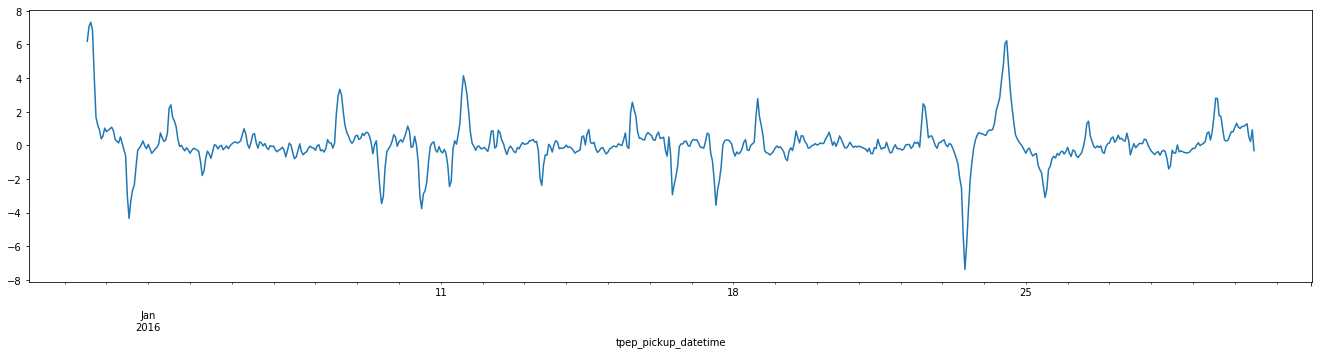

2.568650040015006e-20


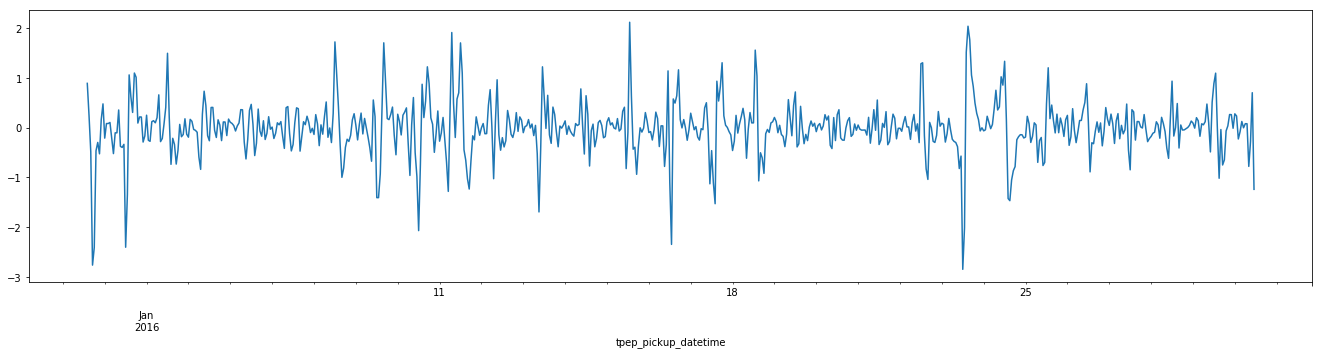

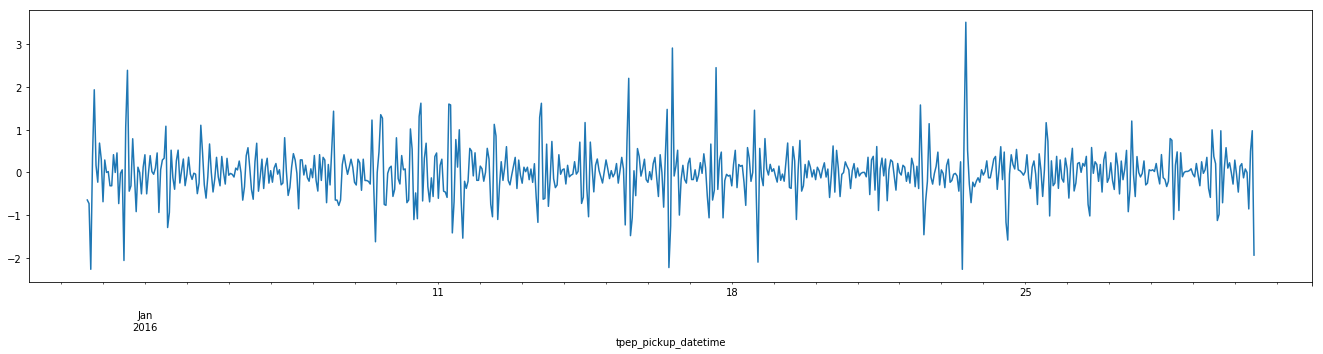

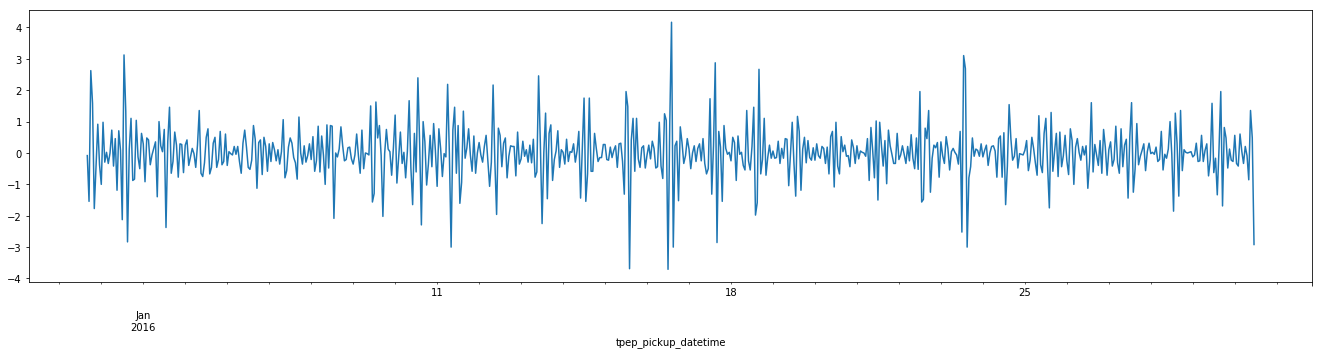

In [22]:
lag2 = 1
data['resid_diff_24_1'] = data['resid_diff_24'] - data['resid_diff_24'].shift(lag2)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_1'][(lag + lag2):])
plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()
print sm.tsa.stattools.adfuller(data['resid_diff_24_1'][(lag + lag2):])[1]

lag3 = 1
data['resid_diff_24_2'] = data['resid_diff_24_1'] - data['resid_diff_24_1'].shift(lag3)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_2'][(lag + lag2 + lag3):])
plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()

lag4 = 1
data['resid_diff_24_3'] = data['resid_diff_24_2'] - data['resid_diff_24_2'].shift(lag4)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_3'][(lag + lag2 + lag3 + lag4):])
plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()


lag5 = 1
data['resid_diff_24_4'] = data['resid_diff_24_3'] - data['resid_diff_24_3'].shift(lag5)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_4'][(lag + lag2 + lag3 + lag4 + lag5):])
plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()


Теперь ряд больше похож на стационарный. Посмотрим на ACF и PACF полученного ряда:

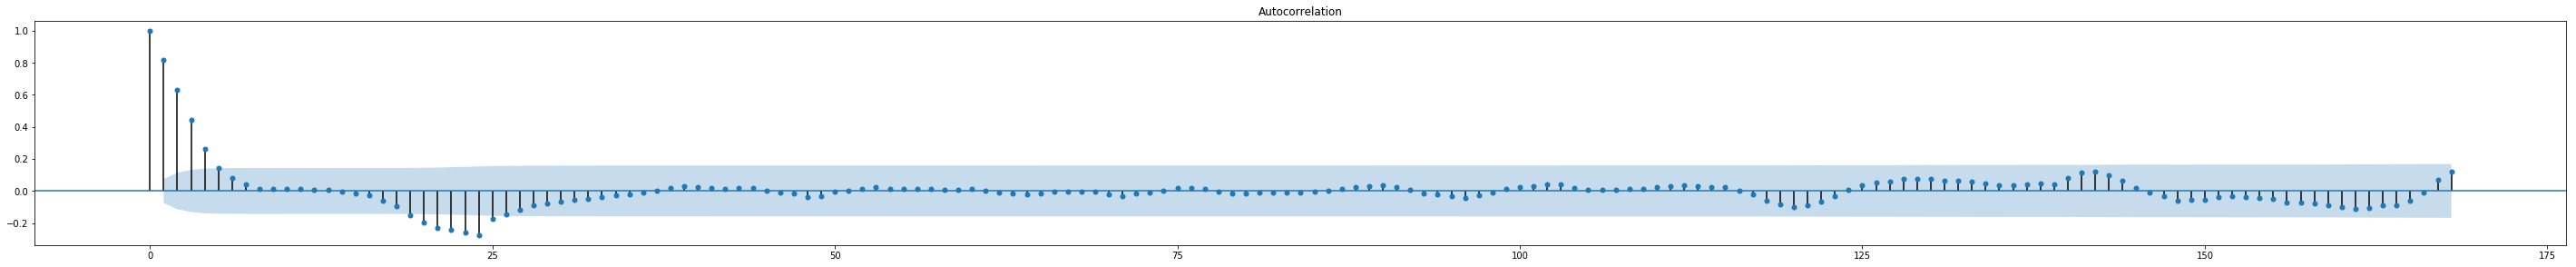

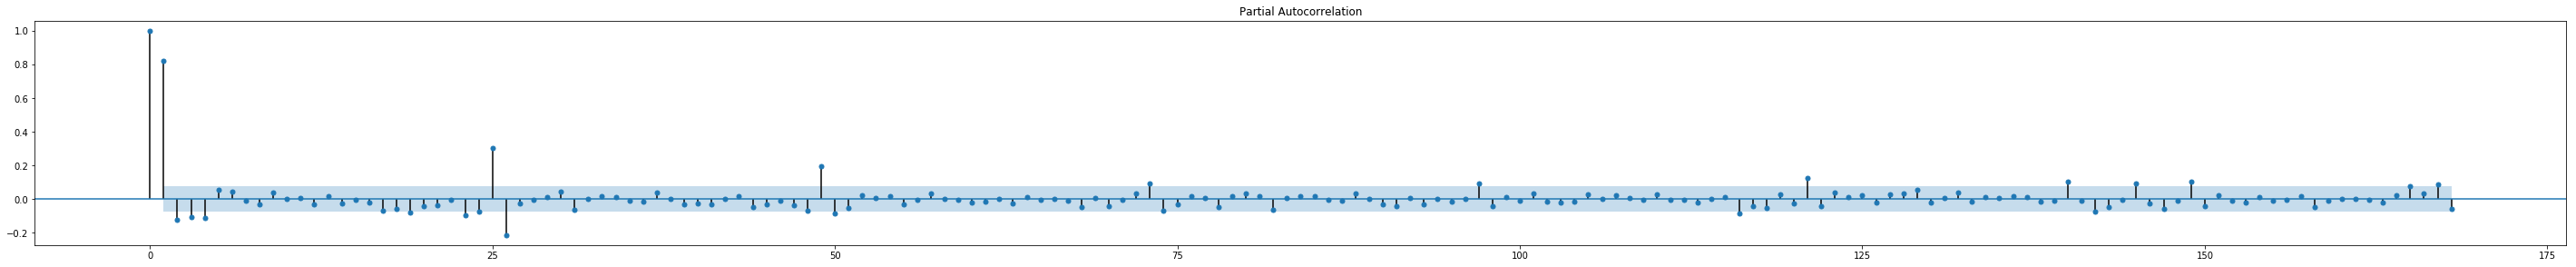

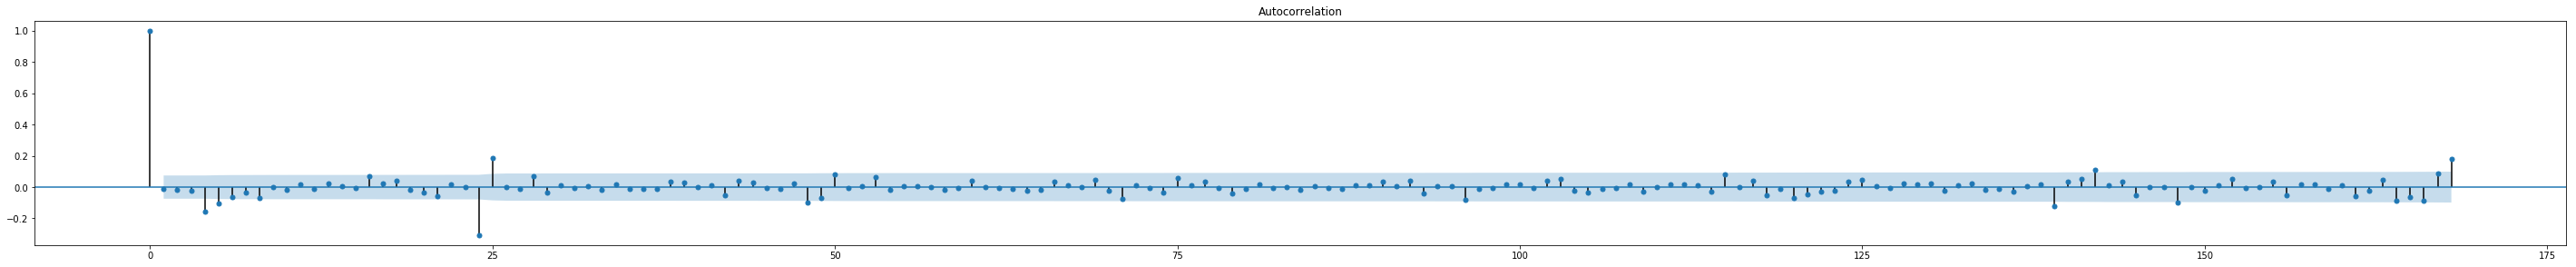

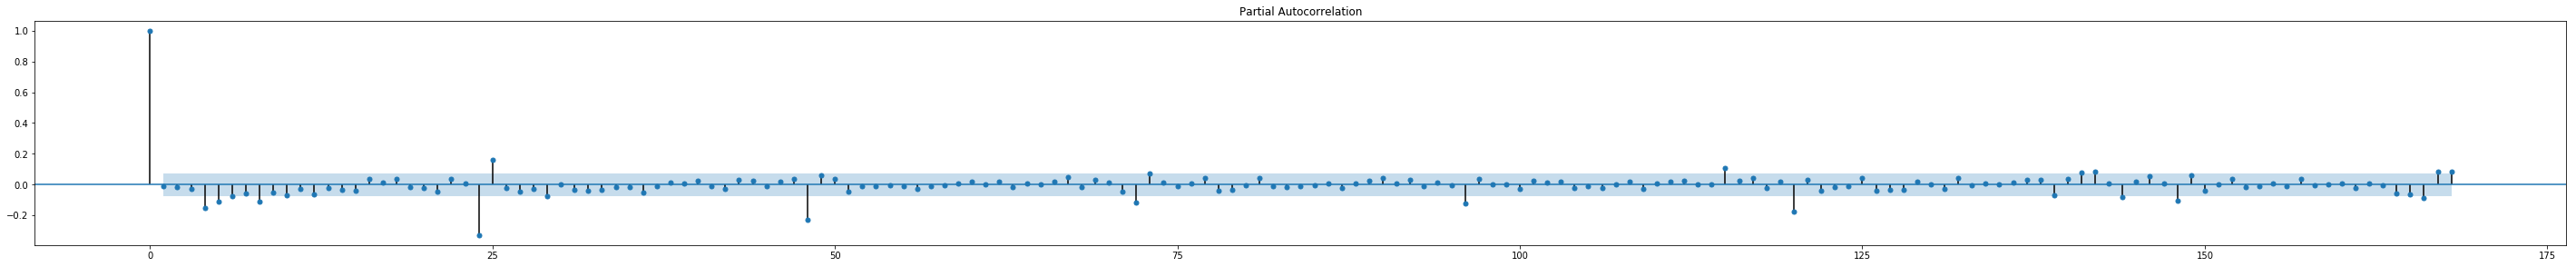

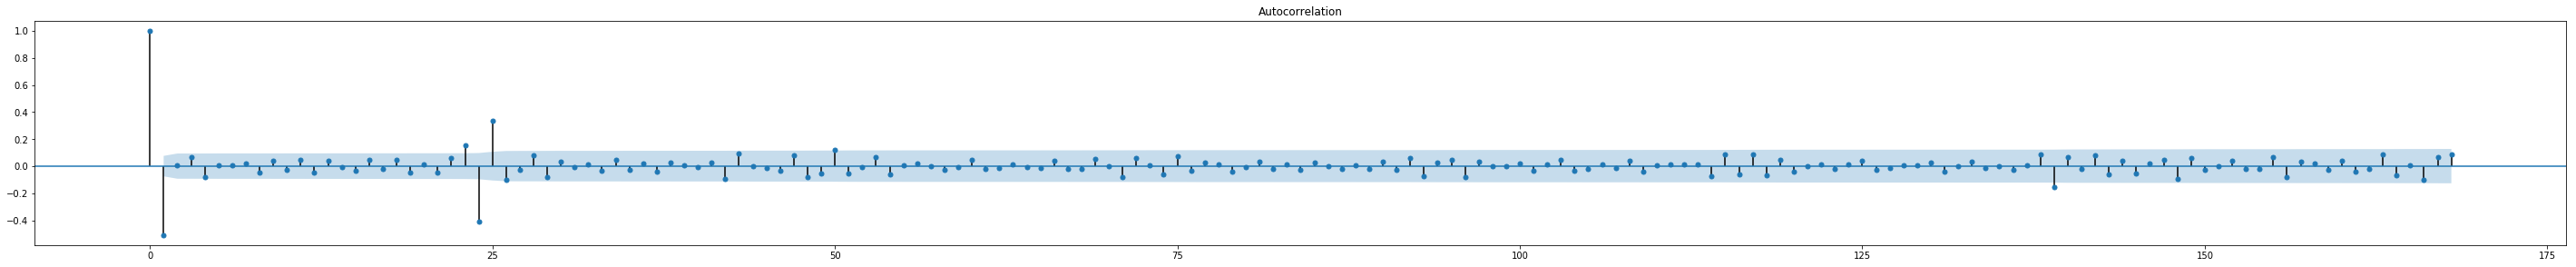

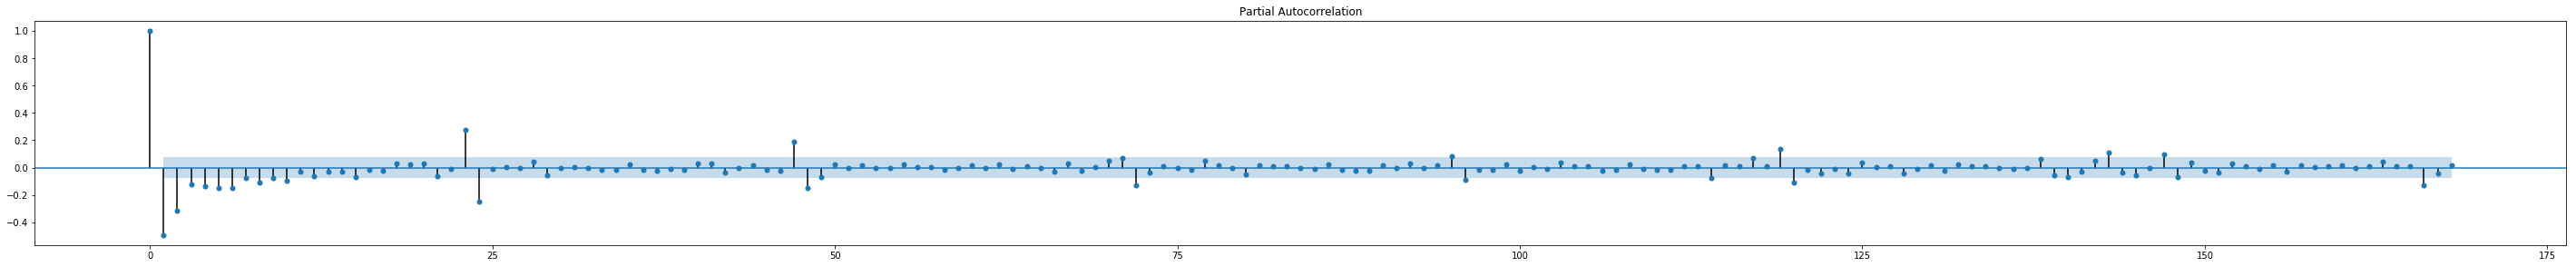

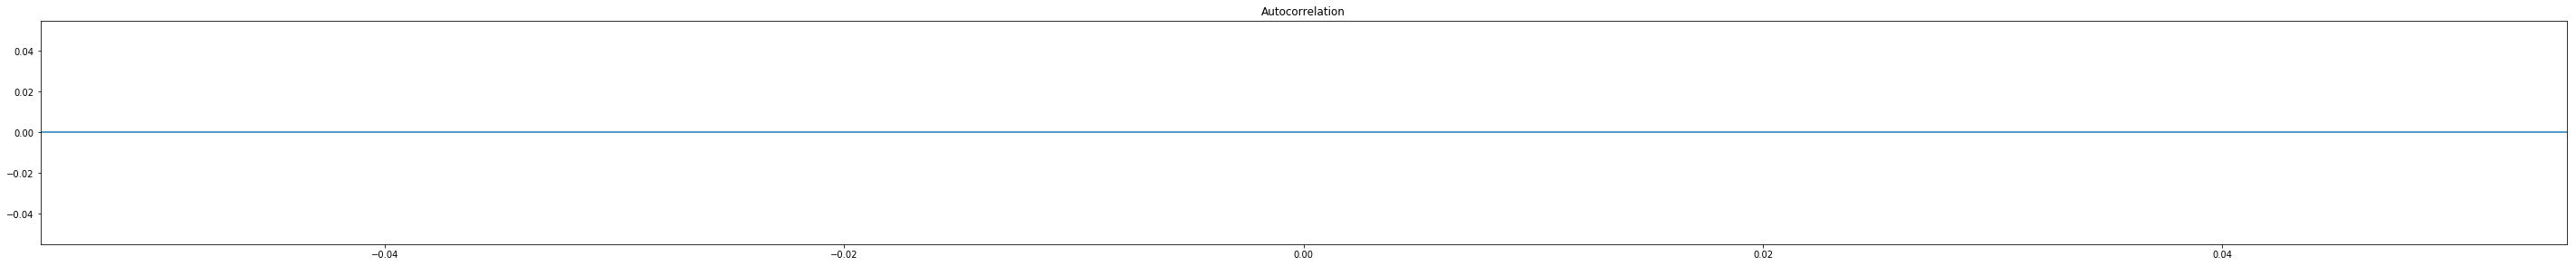

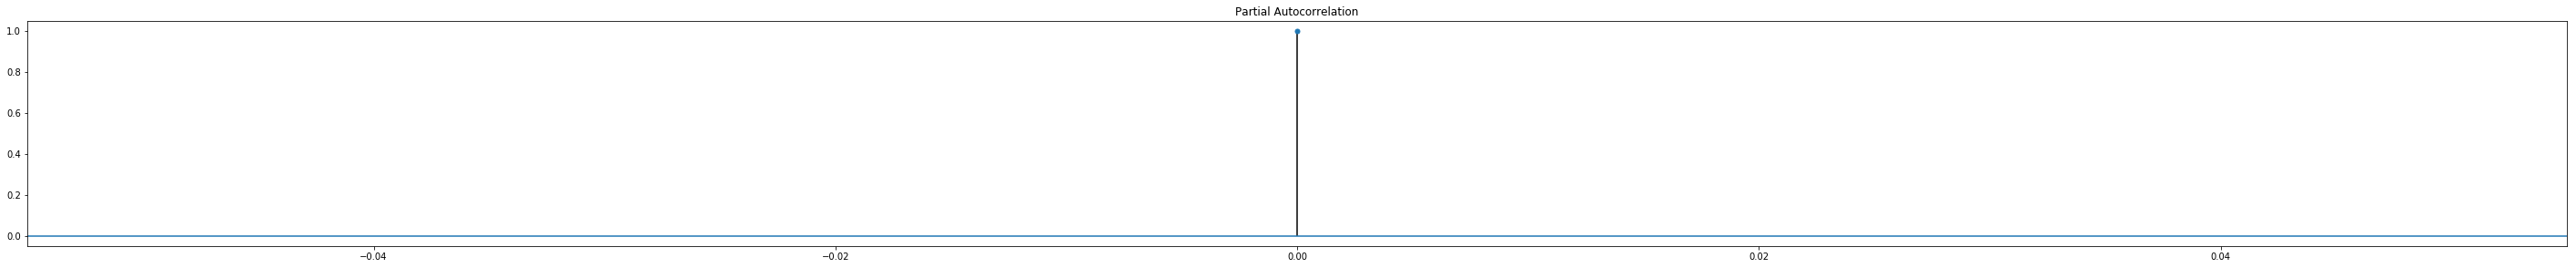

In [23]:
plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24'][(lag):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24'][(lag):].values.squeeze(), lags=168, ax=ax)
pylab.show()

plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24_1'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()

plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24_2'][(lag + lag + lag3):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24_2'][(lag + lag2 + lag3):].values.squeeze(), lags=168, ax=ax)
pylab.show()


plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24_4'][(lag + lag2 + lag3 + lag4):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24_4'][(lag + lag2 + lag3 + lag4):].values.squeeze(), lags=168, ax=ax)
pylab.show()

Подберем начальные приближения для параметров модели исходя из ACF и PACF:

In [24]:
ps = [0, 1, 2, 3, 7, 8, 12]
d =  1
qs = [0, 1, 3, 10, 12]

Ps = [0]
D =  1
Qs = [0, 1]

In [25]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

70


Подберем модель. Будем использовать признаки регресии как параметр exog:

In [30]:
#%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
cnt = 0
for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        print cnt, " > ", param,
        cnt += 1
        model=sm.tsa.statespace.SARIMAX(data['count'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], lag),
                                        #exog=data[x_names]
                                        ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except Exception as e: 
        print e
        print('wrong parameters:', param)
        continue
    aic = model.aic
    print aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

0  >  (0, 0, 0, 0) could not broadcast input array from shape (0,0) into shape (25,25)
('wrong parameters:', (0, 0, 0, 0))
1  >  (0, 0, 0, 1) 5248.350889415187
2  >  (0, 1, 0, 0) 5472.301137468088
3  >  (0, 1, 0, 1) 5240.932540543273
4  >  (0, 3, 0, 0) 5474.270577317377
5  >  (0, 3, 0, 1) 5242.535825046693
6  >  (0, 10, 0, 0) 5415.998843002867
7  >  (0, 10, 0, 1) 5170.286925216003
8  >  (0, 12, 0, 0)

KeyboardInterrupt: 

In [44]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
6  (0, 10, 0, 1)  5170.286925
2   (0, 1, 0, 1)  5240.932541
4   (0, 3, 0, 1)  5242.535825
0   (0, 0, 0, 1)  5248.350889
5  (0, 10, 0, 0)  5415.998843


Изучим модель с наименьшим AIC:

Критерий Стьюдента: p=0.010199
Критерий Дики-Фуллера: p=0.000000


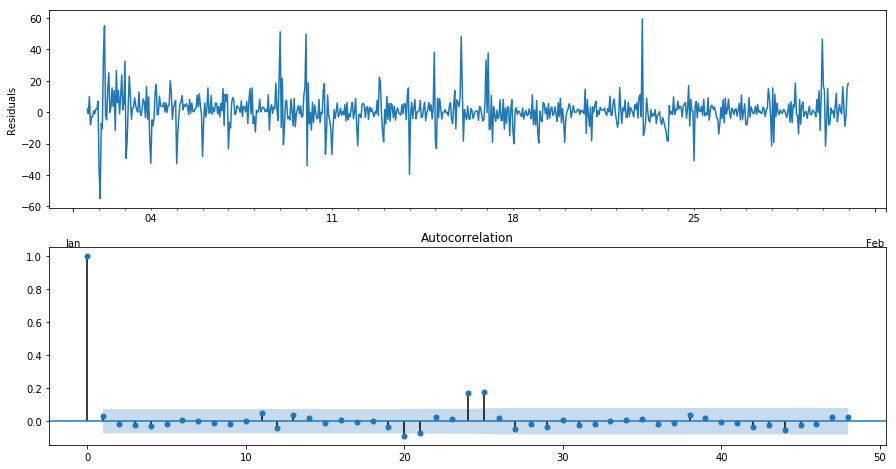

In [45]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sc.stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Однако присутствует некоторая автокореллированность связанная возможно с неполнотой инфорации (признаков) о сезонности.
Посмотрим, насколько хорошо модель описывает данные:

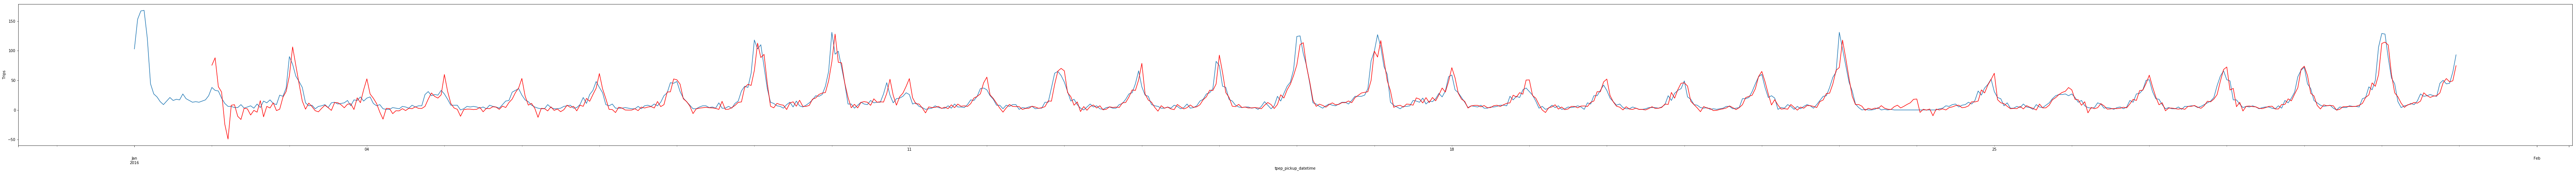

In [46]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(123,7))
data['count'].plot()
data['model'][lag:].plot(color='r')
plt.ylabel('Trips')
pylab.show()

Можно сделать вывод о том что модель неплохо описывает данные, однако можно поработать над улучшение прогнозов внутрисуточной сезонности.
Видно, что модель не очень хорошо прогнозирует значения ряда близкие к средним, они находятся внутри недель(разница между будними и выходными, начало и конец недели).
Как вариант - сгенерировать признаки с для учета внутринедельной сезонности.
Кроме того можно более подробно рассмотреть признаки внутри суток и учесть не только два максимума в течение суток. 


In [386]:
arr1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

arr2 = np.array([[1], [2], [3]])

In [387]:
arr1

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [388]:
arr2

array([[1],
       [2],
       [3]])

In [389]:
arr1 * arr2

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 27]])

In [390]:
np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) * np.array([[1], [2], [3]])

array([[ 1,  2,  3],
       [ 8, 10, 12],
       [21, 24, 27]])

In [391]:
np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]) * np.array([1, 2, 3])

array([[ 1,  4,  9],
       [ 4, 10, 18],
       [ 7, 16, 27]])

In [392]:
!pip install mlpy

  Running setup.py bdist_wheel for mlpy: started
  Running setup.py bdist_wheel for mlpy: finished with status 'done'
  Stored in directory: C:\Users\nlavr\AppData\Local\pip\Cache\wheels\c4\bc\48\6a17b405bb49afa19495429fca8f37a5f544a796a9502d91b0
Successfully built mlpy


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
